In [2]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go
from utils import parse_real_disp, CABC_Displacement, CABC_Force, parse_real_force
import datetime
import pickle

torch.set_default_dtype(torch.float64)

c:\Users\oskay\miniforge3\envs\moldflow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Random Parameter Generation

In [ ]:
# # Bounds
# n_bounds = (0.2, 0.6)
# tau_star_bounds = (1e+3, 1e+5)
# B_bounds = (1e+3, 1e+5)  
# tau_w_bounds = (0.005, 1.0)
# m_bounds = (1.0, 1.9)

# # LHs Sampling
# sampler = qmc.LatinHypercube(d=5)
# sample = sampler.random(30)  # of samples

# # # Scaling
# n_values =              sample[:, 0] * (n_bounds[1] - n_bounds[0]) + n_bounds[0]
# tau_star_values =       sample[:, 1] * (tau_star_bounds[1] - tau_star_bounds[0]) + tau_star_bounds[0]
# B_values =              sample[:, 2] * (B_bounds[1] - B_bounds[0]) + B_bounds[0]
# tau_w_values =          sample[:, 2] * (tau_w_bounds[1] - tau_w_bounds[0]) + tau_w_bounds[0]
# m_values =              sample[:, 3] * (m_bounds[1] - m_bounds[0]) + m_bounds[0]

# # # save2CSV
# df = pd.DataFrame({
#     'n': n_values,
#     'tau_star': tau_star_values,
#     'B': B_values,
#     'tau_w': tau_w_values,
#     'm': m_values
# })
# df.to_csv("combined_LHS_parameters.csv", index=False)

# XML Parsing - Master Curve

In [3]:
# Directories
real_disp_path = "H:\\Real_data\\press_displacement_real.xml"
real_force_path = "H:\\Real_data\\press_force_real.xml"

# Force XML

real_force_time, real_force = parse_real_force(real_force_path)

def calculate_area_between_curves(real_time, real_force, guess_time, guess_disp):
    common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)

    # Resample both curves on this time grid
    real_force_resampled = np.interp(common_time, real_time, real_force)
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    mse = np.mean((real_force_resampled-guess_disp_resampled)**2)
    
    return mse

# real_data_directory = "H:\\Real_data\\press_force_real.xml"
# areas = []
# area_data = []

# real_tree = ET.parse(real_data_directory)
# real_root = real_tree.getroot()
# real_data = []
# guess_data_all = {}

# count = 0

# for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
#     if count >=  27:
#         break  # Stop the loop after collecting 27 values

#     time_value = time_block.attrib.get('Value')
#     dept_value = dept_block.find('DeptValues').text.strip()
#     real_data.append((time_value, dept_value))

#     count += 1

# real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
# real_time = real_data_array[:, 0]  
# real_disp = real_data_array[:, 1]   / 1000

In [4]:
file_info = [
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar03mms388g.txt",  #0
        "force_start"   : "31.07.2025 10:39:06.150461",
        "force_end"     : "31.07.2025 10:39:24.070461",
        "pos_start"     : "31.07.2025 10:39:24.070461",
        "pos_end"       : "31.07.2025 10:42:34.610461"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar07mms384g.txt",  #1
        "force_start"   : "31.07.2025 10:18:27.193997",
        "force_end"     : "31.07.2025 10:18:35.113997",
        "pos_start"     : "31.07.2025 10:18:35.113997",
        "pos_end"       : "31.07.2025 10:20:44.573997"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar11mms414g.txt",  #2
        "force_start"   : "30.07.2025 13:43:44.197899",
        "force_end"     : "30.07.2025 13:43:49.057899",
        "pos_start"     : "30.07.2025 13:43:49.057899",
        "pos_end"       : "30.07.2025 13:46:49.957899"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar03mms396g.txt", #3
        "force_start"   : "29.07.2025 15:27:01.321079",
        "force_end"     : "29.07.2025 15:27:19.181079",
        "pos_start"     : "29.07.2025 15:27:19.181079",
        "pos_end"       : "29.07.2025 15:30:46.881079"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar07mms398g.txt", #4
        "force_start"   : "30.07.2025 12:19:49.167098",
        "force_end"     : "30.07.2025 12:19:57.487098",
        "pos_start"     : "30.07.2025 12:19:57.487098",
        "pos_end"       : "30.07.2025 12:21:55.287098"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar11mms393g.txt", #5
        "force_start"   : "30.07.2025 12:46:38.439119",
        "force_end"     : "30.07.2025 12:46:43.619119",
        "pos_start"     : "30.07.2025 12:46:43.619119",
        "pos_end"       : "30.07.2025 12:50:18.619119"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER200bar11mms365g.txt",#6
        "force_start"   : "31.07.2025 11:00:47.633201",
        "force_end"     : "31.07.2025 11:00:53.213201",
        "pos_start"     : "31.07.2025 11:00:53.213201",
        "pos_end"       : "31.07.2025 11:06:35.493201"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar03mms508g.txt", #7
        "force_start"   : "30.07.2025 11:47:26.451826",
        "force_end"     : "30.07.2025 11:47:42.371826",
        "pos_start"     : "30.07.2025 11:47:42.371826",
        "pos_end"       : "30.07.2025 11:50:53.831826"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar07mms525g.txt", #8
        "force_start"   : "31.07.2025 14:21:37.055615",
        "force_end"     : "31.07.2025 14:21:43.535615",
        "pos_start"     : "31.07.2025 14:21:43.535615",
        "pos_end"       : "31.07.2025 14:24:04.975615"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar11mms531g.txt", #9
        "force_start"   : "31.07.2025 14:49:31.716399",
        "force_end"     : "31.07.2025 14:49:35.816399",
        "pos_start"     : "31.07.2025 14:49:35.816399",
        "pos_end"       : "31.07.2025 15:01:25.776399"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar03mms542g.txt", #10
        "force_start"   : "31.07.2025 09:07:08.361246",
        "force_end"     : "31.07.2025 09:07:23.161246",
        "pos_start"     : "31.07.2025 09:07:24.161246",
        "pos_end"       : "31.07.2025 09:09:48.641246"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar07mms527g.txt", #11
        "force_start"   : "30.07.2025 15:33:47.945013",
        "force_end"     : "30.07.2025 15:33:54.465013",
        "pos_start"     : "30.07.2025 15:33:54.465013",
        "pos_end"       : "30.07.2025 15:36:35.305013"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar11mms543g.txt", #12
        "force_start"   : "31.07.2025 09:56:19.454633",
        "force_end"     : "31.07.2025 09:56:23.494633",
        "pos_start"     : "31.07.2025 09:56:23.494633",
        "pos_end"       : "31.07.2025 09:58:13.974633"  
    },
    {
        "path" : "H:\\DLR Press Data\\SPLITCONF80percent4STACKBAR150bar03mms518g.txt", #13
        "force_start"   : "31.07.2025 15:16:03.864139",
        "force_end"     : "31.07.2025 15:16:18.464139",
        "pos_start"     : "31.07.2025 15:16:18.464139",
        "pos_end"       : "31.07.2025 15:20:00.584139"  
    }

]

custom_groups = [
    [0, 1, 2],    
    [3, 4, 5],    
    [7, 8, 9],
    [10, 11, 12]         
]
custom_groups = [
    [  # 60% BAR config
        {"index": 0, "label": "60% BAR 0.3 mm/s"},
        {"index": 1, "label": "60% BAR 0.7 mm/s"},
        {"index": 2, "label": "60% BAR 1.1 mm/s"}
    ],
    [  # 60% CENTER config
        {"index": 3, "label": "60% CENTER 0.3 mm/s"},
        {"index": 4, "label": "60% CENTER 0.7 mm/s"},
        {"index": 5, "label": "60% CENTER 1.1 mm/s"}
    ],
    [  # 80% BAR
        {"index": 7, "label": "80% BAR 0.3 mm/s"},
        {"index": 8, "label": "80% BAR 0.7 mm/s"},
        {"index": 9, "label": "80% BAR 1.1 mm/s"}
    ],
    [  # 80% BAR
        {"index": 10, "label": "80% CENTER 0.3 mm/s"},
        {"index": 11, "label": "80% CENTER 0.7 mm/s"},
        {"index": 12, "label": "80% CENTER 1.1 mm/s"}
    ],
    

]

In [6]:
df = pd.read_csv('combined_LHS_parameters.csv')

n_values = df['n'].tolist()
tau_star_values = df['tau_star'].tolist()
B_values = df['B'].tolist()
tau_w_values = df['tau_w'].tolist()
m_values = df['m'].tolist()

# Moldflow Simulation

In [15]:
sim_dir = "G:\\Oskay Sözen\\80BAR_11\\80BAR_11.mpi"
init_study = "80BAR_4.70_study"
run_dir = "G:\\Oskay Sözen\\80BAR_11"
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2026\\bin"  #Home D:\\Moldflow Insight 2023\\bin       #WS "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"  #"G:\\Oskay Sözen\\wall_slip\\wall slip.mpi"

# CHANGE THE LOG AND XML FILES FOR EVERY CONFIG

In [ ]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")

Synergy.OpenProject(sim_dir)
Project = Synergy.Project
Project.OpenItemByName(init_study, "Study")



# Simulation loop for wall slip parameters
for i in range(30):
    
    t0 = time.perf_counter()
    n = n_values[i]
    tau_star = tau_star_values[i]
    B = B_values[i]
    tau_w = tau_w_values[i]
    m = m_values[i]


    print(f"Simulation {i+1} with \nn : {n}\ntau_star :  {tau_star}\nB : {B}\ntau_w :  {tau_w}\nm : {m}")

    study_name = f"study_{i+1}"
    Project = Synergy.Project

    # Viscosity Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090,1)
    Prop.FieldDescription(53030, f"{n}, {tau_star}, {B}, 0.004, 0, 0, 0.305")
    PropEd.CommitChanges("Process Conditions")

    # Wall Slip Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(tau_w)
    DVec.AddDouble(m)
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
        
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\80BAR_11\\study_{i+1}.sdy"],     #config name change
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    t1 = time.perf_counter(); print("Solver took", t1-t0)
    time.sleep(3)

    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(5)

    Synergy.OpenProject(sim_dir)         # PROJECT NAME!!!!!!!!!!!!!!!!
    Project = Synergy.Project
    Project.OpenItemByName(f"{study_name}", "Study")

    # Plot Export

    PlotMgr = Synergy.PlotManager
    time.sleep(3)
    Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(3)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\80BAR_11\\study_{i+1}.xml", "Metric")
    t2 = time.perf_counter(); print("XML took", t2-t1)
# Write the output to a log file
    with open(f"H:\\Log_Files\\80BAR_11\\study_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())



Simulation 1 with 
n : 0.3523167884640847
tau_star :  51618.73809515864
B : 93252.00321719507
tau_w :  0.9321792242536272
m : 1.6257620865003508
Solver took 902.0512999000493
XML took 20.722494399989955
Simulation 2 with 
n : 0.300712351550607
tau_star :  22165.28284425984
B : 4171.585797195823
tau_w :  0.0368760390728267
m : 1.7114707058541667
Solver took 761.1944401999936
XML took 20.680373599985614
Simulation 3 with 
n : 0.3902951556015092
tau_star :  54824.59613245916
B : 38384.68032187044
tau_w :  0.3807349183864756
m : 1.1226876906818568
Solver took 723.7804887000239
XML took 20.93583969993051
Simulation 4 with 
n : 0.2017878488703992
tau_star :  30891.829779950676
B : 17806.985421531026
tau_w :  0.1739186918628623
m : 1.5524628382419745
Solver took 882.7178327000001
XML took 20.81202850001864
Simulation 5 with 
n : 0.263011310423122
tau_star :  82655.50730953168
B : 9410.50948875795
tau_w :  0.0895298680940824
m : 1.1816447053347805
Solver took 695.6423174999654
XML took 20.7997

# XML Parsing - Guess Curves

In [41]:
guess_disp_data_all = {}
guess_force_data_all = {}
area_data = []
guess_data_all = {}
valid_xml = []
num_initial_samples = 30
for i in range(num_initial_samples):
        guess_tree = ET.parse(f"H:\\XMLFiles\\80BAR_11\\study_{i + 1}.xml")
        guess_root = guess_tree.getroot()
        guess_data = []

        count = 0
                
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
                if count >= 23:
                        break


                time_value = time_block.attrib.get('Value')
                dept_value = dept_block.find('DeptValues').text.strip()
                
                guess_data.append((time_value, dept_value))

                count += 1
        if len(guess_data) < 23:
                print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
                continue

        guess_data_all[f"guess_data_{i+1}"] = guess_data

        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1] * 9.80665

        globals()[f"guess_time_{i+1}"] = guess_time
        globals()[f"guess_disp_{i+1}"] = guess_disp 


        mean_s_error = calculate_area_between_curves(real_time, real_force, guess_time, guess_disp)
        area_data.append(mean_s_error)
        valid_xml.append(len(area_data) - 1)

        
print(guess_data_all)

{'guess_data_1': [('0.003334', '2.5669e+00'), ('0.068765', '2.9870e+00'), ('0.545763', '2.9902e+00'), ('1.307756', '3.3416e+00'), ('1.828318', '4.4187e+00'), ('2.451796', '5.3771e+00'), ('2.879154', '6.2003e+00'), ('3.405224', '6.8455e+00'), ('4.051563', '7.6036e+00'), ('4.485187', '8.5080e+00'), ('5.011768', '9.3077e+00'), ('5.465565', '1.0401e+01'), ('6.048372', '1.1470e+01'), ('6.470971', '1.3203e+01'), ('6.989615', '1.4528e+01'), ('7.352518', '1.6130e+01'), ('7.789419', '1.7719e+01'), ('8.243102', '1.9568e+01'), ('8.637798', '2.2062e+01'), ('9.113828', '2.4071e+01'), ('9.507250', '2.7468e+01'), ('9.888264', '2.9927e+01'), ('10.210508', '3.3332e+01')], 'guess_data_2': [('0.003334', '2.8422e-01'), ('0.056410', '2.4847e-01'), ('0.443339', '2.4944e-01'), ('1.208320', '2.7570e-01'), ('1.712094', '3.4202e-01'), ('2.358812', '4.7612e-01'), ('2.813743', '5.7014e-01'), ('3.387650', '6.3058e-01'), ('4.006558', '7.1377e-01'), ('4.379522', '8.2132e-01'), ('4.843118', '8.9914e-01'), ('5.399730'

In [37]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[np.float64(10228.521433641401), np.float64(254.19807476315486), np.float64(3187.8985039842864), np.float64(99.57258579071677), np.float64(71.52566575342749), np.float64(4672.928898091372), np.float64(399.41805920080486), np.float64(18598.31281512199), np.float64(563.6450541684466), np.float64(24892.449550241054), np.float64(1439.8800642261076), np.float64(11159.194958450125), np.float64(16713.356214808588), np.float64(276.56414143955345), np.float64(733.8742070908103), np.float64(521.4585416830549), np.float64(8781.472009057383), np.float64(2684.281734055452), np.float64(1501.2964480894004), np.float64(7024.826109662054), np.float64(8488.49194814216), np.float64(12.69878410743806), np.float64(15509.600188011327), np.float64(9587.00946662214), np.float64(2621.2660241999497), np.float64(1339.6828118596695), np.float64(7417.541709095571), np.float64(107.51969065905445), np.float64(3829.529949805708), np.float64(151.76307398725422)]
['guess_data_1', 'guess_data_2', 'guess_data_3', 'guess_

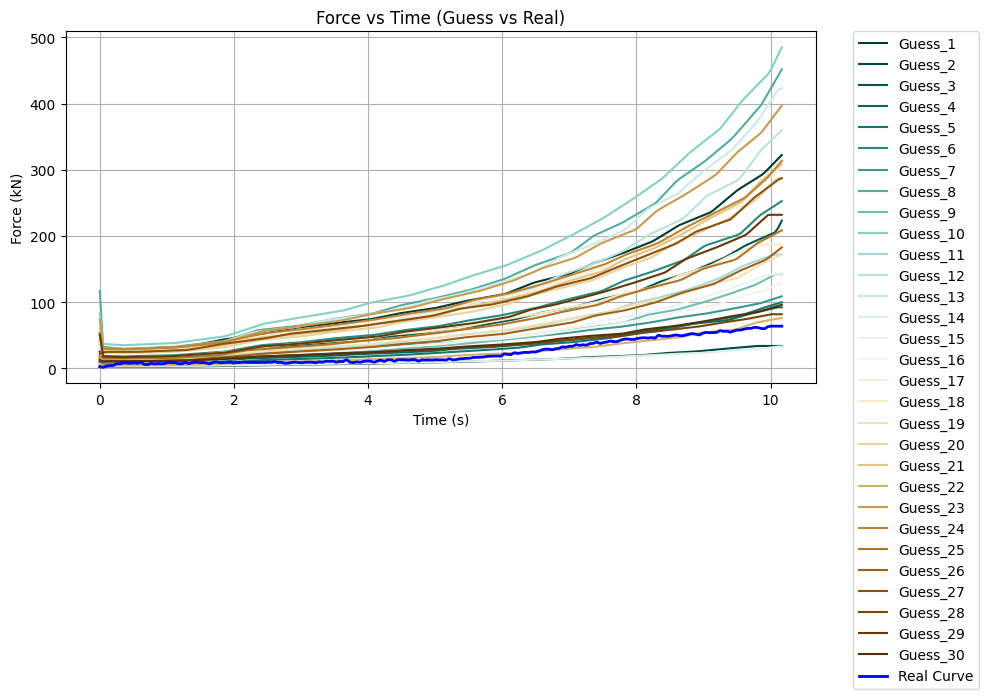

In [42]:
common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)
real_force_resampled = np.interp(common_time, real_time, real_force)

num_curves = len(guess_data_all)
colormap = plt.get_cmap('BrBG_r')

plt.figure(figsize=(10, 6))

for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_force = guess_data_array[:, 1] * 9.80665

    guess_force_resampled = np.interp(common_time, guess_time, guess_force)
    color = colormap((i - 1) / max(num_curves - 1, 1))
    plt.plot(common_time, guess_force_resampled, color=color, label=f'Guess_{i}')

plt.plot(common_time, real_force_resampled, 'b-', label='Real Curve', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
plt.title('Force vs Time (Guess vs Real)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


# GP Model

In [ ]:
file_path = 'H:\\moldflow\\moldflow_automation\\combined_LHS_parameters.csv'
data = pd.read_csv(file_path)
n_values = data['n'].values
tau_star_values = data['tau_star'].values
B_values = data['B'].values
tau_w_values = data['tau_w'].values
m_values = data['m'].values

train_x = torch.tensor([[n_values[i], tau_star_values[i], B_values[i], tau_w_values[i], m_values[i]] for i in valid_xml ], dtype=torch.float64)
train_y = - torch.tensor([[area_data[i]] for i in valid_xml], dtype=torch.float64)
train_yvar = torch.full_like(train_y, 1e-6)



bounds = torch.tensor([
    [0.2, 1e+3, 1e+3, 0.005, 1.0],
    [0.6, 1e+5, 1e+5, 1.0, 1.9]
], dtype= torch.float64
)

outcome_transform = Standardize(m=1)
input_transform = Normalize(d=5)

# GP Model 
model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
model.eval()  


acq_func =  LogExpectedImprovement(model, best_f=train_y.max().item())

candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=100, #Helps to ensure that we find the global optimum instead of finding the local optimum
        raw_samples=5000,  #More samples increases likelihood of finding good starting point.
)

cand = model(input_transform(candidate))
cand_var = torch.diagonal(cand.covariance_matrix, 0)
cand_mean, cand_std = outcome_transform.untransform(cand.mean, cand_var)


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


In [13]:
print(candidate)
print(train_y)
print(train_x)
bounds.shape

tensor([[4.9180e-01, 1.2203e+05, 9.3839e+05, 5.8824e-01, 1.7004e+00]])
tensor([[-308743.8030],
        [ -66622.8992],
        [ -71868.9232],
        [ -41776.4670],
        [-147536.3210],
        [ -17342.2748],
        [ -95755.3648],
        [-238751.9977],
        [ -59194.8011],
        [ -37722.2308],
        [-132454.3455],
        [ -39159.9466],
        [-221207.8469],
        [-121806.7404],
        [ -48061.5836]])
tensor([[3.9853e-01, 3.2151e+05, 1.3000e+05, 3.8165e-02, 1.3233e+00],
        [3.7594e-01, 5.6179e+05, 5.7062e+05, 5.2529e-01, 1.6379e+00],
        [2.4503e-01, 8.5526e+05, 9.9179e+05, 9.9092e-01, 1.4564e+00],
        [5.6047e-01, 4.0429e+05, 8.5957e+05, 8.4475e-01, 1.0285e+00],
        [5.1786e-01, 7.7642e+05, 4.1198e+05, 3.4991e-01, 1.6809e+00],
        [4.2652e-01, 2.7940e+05, 6.8137e+05, 6.4774e-01, 1.5842e+00],
        [5.4053e-01, 6.1675e+05, 5.0050e+05, 4.4777e-01, 1.8024e+00],
        [4.8847e-01, 7.4631e+05, 2.7623e+05, 1.9984e-01, 1.7783e+00],
        

torch.Size([2, 5])

# Optimization CHECK CANDIDATE


In [14]:
# ---- CHANGE THIS FOR EACH RUN ----
run_name = "80CENTER-03mm-s"  

save_dir = os.path.join(os.getcwd(), run_name)
os.makedirs(save_dir, exist_ok=True)

print(f"Saving all run data to: {save_dir}")


guess_data_all_optim = {}
num_iteration = 50
iterations=[]

for i in range(num_iteration):
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=5)

    model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()  

    acq_func =  LogExpectedImprovement(model, best_f=train_y.max())


    candidate_optim, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts=100, #Helps to ensure that we find the global optimum instead of finding the local optimum
            raw_samples=5000,  #More samples increases likelihood of finding good starting point.
    )

    print(f"Iteration {i+1}: Suggested new parameters (n, tau_star, B, tau_w, m)", candidate_optim)
    iterations.append(candidate_optim)

    study_name = f"optimization_{i+1}"
    Project = Synergy.Project

    # Viscosity Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090,1)
    Prop.FieldDescription(53030, f"{candidate_optim[0,0].item()}, {candidate_optim[0,1].item()}, {candidate_optim[0,2].item()} , 0.004, 0, 0, 0.305")
    PropEd.CommitChanges("Process Conditions")

    # Wall Slip Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(candidate_optim[0,3].item())
    DVec.AddDouble(candidate_optim[0,4].item())
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
        
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\Parameter\\optimization_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    time.sleep(3)
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"])
    time.sleep(2)

    Synergy.OpenProject("G:\\Oskay Sözen\\Parameter\\Parameter.mpi")         # PROJECT NAME!!!!!!!!!!!!!!!!
    Project = Synergy.Project
    Project.OpenItemByName(f"optimization_{i+1}", "Study")

    # Plot Export

    PlotMgr = Synergy.PlotManager
    time.sleep(2)
    Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(2)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\optimization_{i + 1}.xml", "Metric")



# Write the output to a log file
    with open(f"H:\\Log_Files\\optimization_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

    guess_tree = ET.parse(f"H:\\XMLFiles\\optimization_{i+1}.xml")
    guess_root = guess_tree.getroot()
    guess_data = []
    time.sleep(1) 
    count = 0   
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
        if count >= 30:
            break
        
        time_value = time_block.attrib.get('Value')
        dept_value = dept_block.find('DeptValues').text.strip()
        guess_data.append((time_value, dept_value))

        count += 1
    if len(guess_data) < 30:
        print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
        continue
    guess_data_all_optim[f"guess_data_{i+1}"] = guess_data

    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]  
    guess_disp = guess_data_array[:, 1]  * 9.80665
        
    globals()[f"guess_time_{num_initial_samples + num_iteration}"] = guess_time
    globals()[f"guess_disp_{num_initial_samples + num_iteration}"] = guess_disp
    
    mean_s_error = calculate_area_between_curves(real_time, real_force, guess_time, guess_disp)
    area_data.append(mean_s_error)
    valid_xml.append(len(area_data) - 1)

    # New Values

    train_x = torch.cat([train_x, candidate_optim], dim=0)
    train_y = torch.cat([train_y, -torch.tensor([[area_data[-1]]])], dim=0)
    train_yvar = torch.full_like(train_y, 1e-6)

    current_best_area = train_y.max().item()

    if abs(current_best_area) < 1e+2:
        print(f"Converged after {i+1} iteration")
        break
    
best_params = train_x[train_y.argmax()]
best_area = train_y.max().item()
print(f"Best parameters (n, tau_star, B, tau_w, m): {best_params}, with MSE : {best_area}")

Saving all run data to: h:\moldflow\moldflow_automation\80CENTER-03mm-s


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 1: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.9367e-01, 1.1045e+05, 6.4555e+05, 9.0209e-01, 1.6950e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 2: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 1.2805e+05, 7.6849e+05, 2.6133e-01, 1.4575e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 3: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.2344e-01, 1.1215e+05, 1.2891e+05, 6.7772e-01, 1.0781e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 4: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.5118e-01, 1.9199e+05, 7.1017e+05, 7.5160e-01, 1.0744e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 5: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.9270e-01, 1.8062e+05, 7.2521e+05, 7.5489e-01, 1.6440e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 6: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[3.8061e-01, 2.9418e+05, 8.4378e+05, 7.0444e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 7: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.3755e-01, 5.0085e+05, 7.5836e+05, 7.8514e-01, 1.5352e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 8: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.5741e-01, 2.0101e+05, 7.7599e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 9: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.8226e-01, 1.1987e+05, 7.0052e+05, 1.0000e+00, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 10: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 5.4449e+05, 4.5882e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 11: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 1.6390e+05, 6.1184e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 12: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.7726e-01, 9.8258e+05, 1.1731e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 13: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.7663e-01, 9.5140e+05, 5.3935e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 14: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.1290e-01, 7.3464e+05, 9.8181e+05, 5.2386e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 15: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.3260e-01, 1.8924e+05, 9.5735e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 16: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0000e-01, 9.9946e+05, 6.9680e+05, 2.2920e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 17: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0000e-01, 5.5421e+05, 9.9355e+05, 5.0000e-03, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 18: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.4214e-01, 1.1303e+05, 8.3039e+05, 6.3528e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 19: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.7048e-01, 1.2818e+05, 9.0602e+05, 5.8395e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 20: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0000e-01, 9.5375e+05, 9.1527e+05, 4.2998e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 21: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.6904e-01, 7.4907e+05, 8.3545e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 22: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0309e-01, 9.4833e+05, 9.5591e+05, 6.1393e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 23: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.4349e-01, 1.2030e+05, 7.9052e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 24: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[3.5462e-01, 9.8085e+05, 5.0808e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 25: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.0216e-01, 5.7820e+05, 5.3938e+05, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 26: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 1.0389e+05, 5.5344e+05, 6.1199e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 27: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 3.2904e+05, 6.2935e+05, 1.0000e+00, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 28: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[3.3185e-01, 8.3795e+05, 9.8964e+05, 5.5822e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 29: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 1.3999e+05, 9.5144e+05, 1.0000e+00, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 30: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 2.1029e+05, 7.0587e+05, 1.0000e+00, 1.3163e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 31: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0000e-01, 6.9434e+05, 8.8837e+05, 5.8655e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 32: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 9.7223e+05, 4.6050e+05, 1.0000e+00, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 33: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.8890e-01, 9.3698e+05, 6.1336e+05, 8.4948e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 34: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.5848e-01, 9.6904e+05, 5.0155e+05, 1.0000e+00, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 35: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 8.7377e+05, 4.6188e+05, 8.0185e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 36: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[4.0664e-01, 1.2285e+05, 7.1041e+05, 6.7511e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 37: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.5343e-01, 9.9806e+05, 4.7087e+05, 7.5625e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 38: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[3.0086e-01, 4.3456e+05, 8.7158e+05, 5.8596e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 39: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.1161e-01, 9.7690e+05, 5.2095e+05, 8.6628e-01, 1.6205e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 40: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 2.4124e+05, 6.5351e+05, 6.3880e-01, 1.0799e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 41: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.1919e-01, 1.1435e+05, 8.4794e+05, 1.0000e+00, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 42: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 3.1775e+05, 5.7121e+05, 7.2258e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 43: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0000e-01, 3.7182e+05, 9.9237e+05, 5.7180e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 44: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 2.0105e+05, 6.8110e+05, 8.9054e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 45: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[5.1690e-01, 1.8515e+05, 6.6150e+05, 6.6654e-01, 1.2996e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 46: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 9.8326e+05, 3.5011e+05, 6.9020e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 47: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0000e-01, 5.7781e+05, 9.4164e+05, 4.5082e-01, 1.0000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 48: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 6.9682e+05, 4.6792e+05, 7.0333e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 49: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 9.7742e+05, 4.7665e+05, 7.2932e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 50: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[6.0000e-01, 2.7438e+05, 6.3204e+05, 9.3683e-01, 1.9000e+00]])
Best parameters (n, tau_star, B, tau_w, m): tensor([6.0000e-01, 3.2904e+05, 6.2935e+05, 1.0000e+00, 1.0000e+00]), with MSE : -12916.346326669767


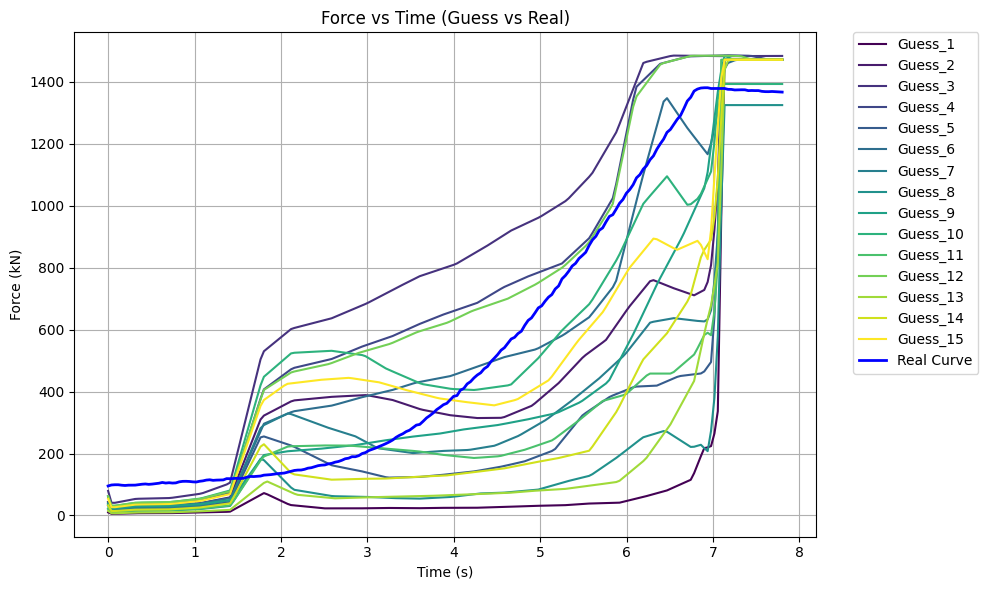

In [15]:
num_curves = len(guess_data_all)
colormap = plt.get_cmap('viridis')

plt.figure(figsize=(10, 6))

for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_force = guess_data_array[:, 1] * 9.80665

    guess_force_resampled = np.interp(common_time, guess_time, guess_force)
    color = colormap((i - 1) / max(num_curves - 1, 1))
    plt.plot(common_time, guess_force_resampled, color=color, label=f'Guess_{i}')

plt.plot(common_time, real_force_resampled, 'b-', label='Real Curve', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
plt.title('Force vs Time (Guess vs Real)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_45888\1177853461.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


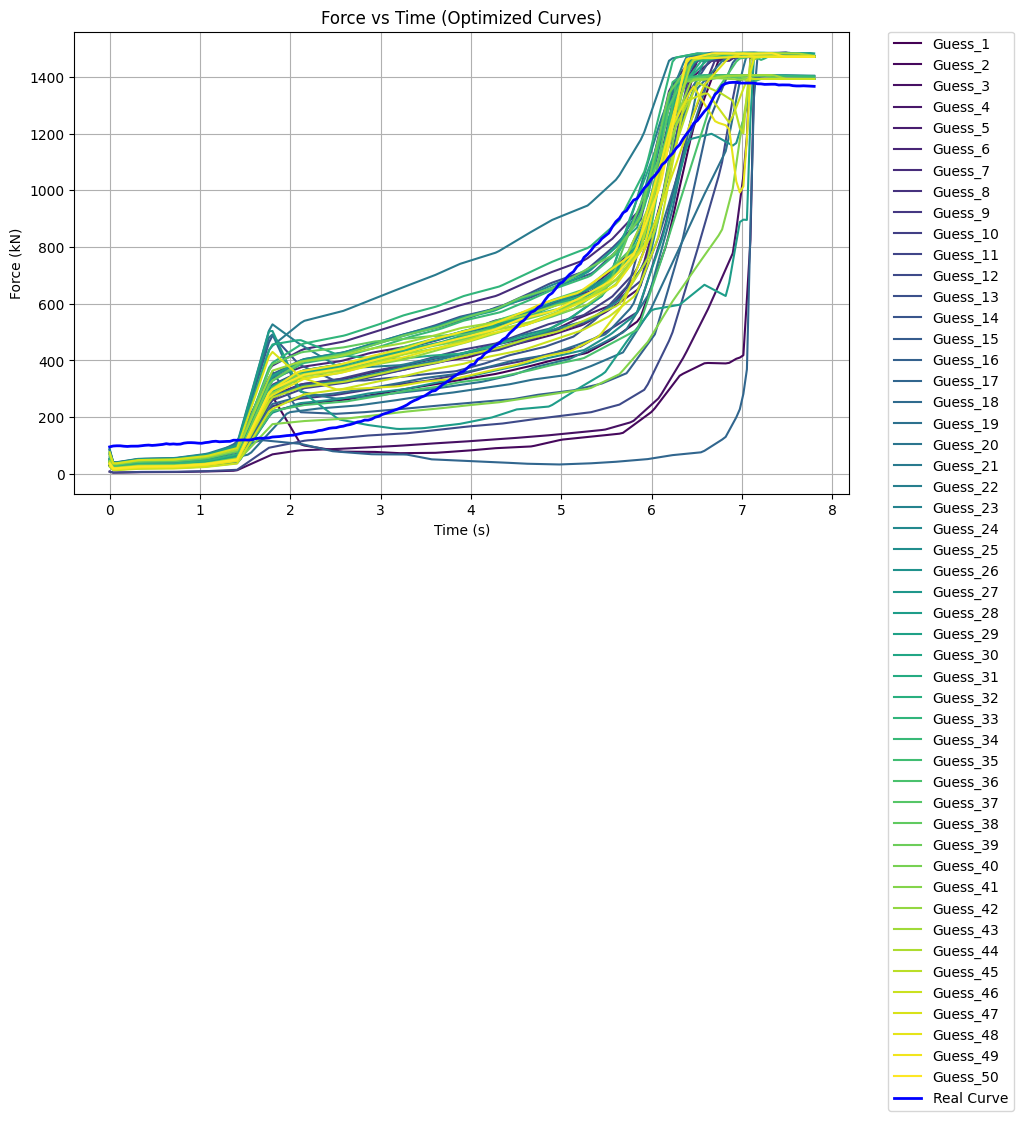

In [16]:

num_curves = len(guess_data_all_optim)
colormap = plt.get_cmap('viridis', num_curves)  
plt.figure(figsize=(10, 6))
for i, (key, guess_data) in enumerate(guess_data_all_optim.items()):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1] * 9.80665

        guess_force_resampled = np.interp(common_time, guess_time, guess_disp)

        color = colormap(i) 
        plt.plot(common_time, guess_force_resampled, color=color, label=f'Guess_{i+1}')
plt.plot(common_time, real_force_resampled, 'b-', label='Real Curve', linewidth=2)
# Finalize plot
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
plt.title('Force vs Time (Optimized Curves)')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()  
plt.show()

In [19]:
np.save(os.path.join(save_dir, "area_data.npy"), np.array(area_data))
np.save(os.path.join(save_dir, "valid_xml.npy"), np.array(valid_xml))

train_df = pd.DataFrame(
    train_x.numpy(),
    columns=["n", "tau_star","B", "tau_w", "m"]
)
train_df["neg_MSE"] = train_y.numpy()
train_df.to_csv(os.path.join(save_dir, "train_data.csv"), index=False)

best_df = pd.DataFrame([best_params.numpy()], columns=["n", "tau_star","B", "tau_w", "m"])
best_df["best_area"] = [best_area]
best_df.to_csv(os.path.join(save_dir, "best_params.csv"), index=False)

with open(os.path.join(save_dir, "guess_data_all.pkl"), "wb") as f:
    pickle.dump(guess_data_all, f)

with open(os.path.join(save_dir, "guess_data_all_optim.pkl"), "wb") as f:
    pickle.dump(guess_data_all_optim, f)

np.savez(
    os.path.join(save_dir, "resampled_curves.npz"),
    common_time=common_time,
    real_force_resampled=real_force_resampled
)
